In [1]:
import pandas as pd
# from google.colab import drive
# import warnings
# warnings.filterwarnings("ignore")
import sklearn
from tqdm import tqdm
import networkx as nx
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn import preprocessing as p
import math
import numpy as np
import collections
from scipy.spatial import Voronoi, voronoi_plot_2d
# from shapely.geometry import Polygon
import scipy as sp
import scipy.spatial
import sys
import matplotlib.image as mpimg
import sklearn.metrics as metrics
from sklearn.calibration import calibration_curve
from spektral.data import Dataset, Graph, DisjointLoader
from spektral.layers import CrystalConv, GlobalAvgPool
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
folder = r'C:\Users\Mahender\Documents\MS docs\Final docs\Rowan University\Research_project'

In [3]:
def data_cleaning(data):
    data = data.copy()
    column_names = data.columns.tolist()
    
    if column_names[3] == 'Player11':  # Home team
        data = data.rename(columns={'Player11': '11_x', 'Unnamed: 4': '11_y', 'Player1': '1_x',
                                    'Unnamed: 6': '1_y', 'Player2': '2_x', 'Unnamed: 8': '2_y', 'Player3': '3_x',
                                    'Unnamed: 10': '3_y', 'Player4': '4_x', 'Unnamed: 12': '4_y', 'Player5': '5_x',
                                    'Unnamed: 14': '5_y', 'Player6': '6_x', 'Unnamed: 16': '6_y', 'Player7': '7_x',
                                    'Unnamed: 18': '7_y', 'Player8': '8_x', 'Unnamed: 20': '8_y', 'Player9': '9_x',
                                    'Unnamed: 22': '9_y', 'Player10': '10_x', 'Unnamed: 24': '10_y',
                                    'Player12': '12_x', 'Unnamed: 26': '12_y', 'Player13': '13_x', 'Unnamed: 28': '13_y',
                                    'Player14': '14_x', 'Unnamed: 30': '14_y', 'Ball': 'Ball_x', 'Unnamed: 32': 'Ball_y'}).copy()
        main_players = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
        subs = [12, 13, 14]
        sub_dict = {i: subs for i in main_players}
    else:  # Away team
        data = data.rename(columns={'Player25': '25_x', 'Unnamed: 4': '25_y', 'Player15': '15_x',
                                    'Unnamed: 6': '15_y', 'Player16': '16_x', 'Unnamed: 8': '16_y',
                                    'Player17': '17_x', 'Unnamed: 10': '17_y', 'Player18': '18_x', 'Unnamed: 12': '18_y',
                                    'Player19': '19_x', 'Unnamed: 14': '19_y', 'Player20': '20_x', 'Unnamed: 16': '20_y',
                                    'Player21': '21_x', 'Unnamed: 18': '21_y', 'Player22': '22_x', 'Unnamed: 20': '22_y',
                                    'Player23': '23_x', 'Unnamed: 22': '23_y', 'Player24': '24_x', 'Unnamed: 24': '24_y',
                                    'Player26': '26_x', 'Unnamed: 26': '26_y', 'Player27': '27_x', 'Unnamed: 28': '27_y',
                                    'Player28': '28_x', 'Unnamed: 30': '28_y', 'Ball': 'Ball_x', 'Unnamed: 32': 'Ball_y'}).copy()
        main_players = [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
        subs = [26, 27, 28]
        sub_dict = {i: subs for i in main_players}
    
    for frame, row in data.iterrows():
        used_subs = set()  # Track used substitutes for each frame
        for main in main_players:
            main_x, main_y = f'{main}_x', f'{main}_y'
            if pd.isna(row[main_x]) or pd.isna(row[main_y]):
                found_sub = False
                for sub in sub_dict[main]:
                    sub_x, sub_y = f'{sub}_x', f'{sub}_y'
                    if sub not in used_subs and not pd.isna(row[sub_x]) and not pd.isna(row[sub_y]):
                        data.at[frame, main_x] = row[sub_x]
                        data.at[frame, main_y] = row[sub_y]
                        used_subs.add(sub)  # Mark this substitute as used
                        found_sub = True
                        break
                if not found_sub:
                    print(f"Frame: {frame}, Player: {main} has NaN values with no valid substitutes.")
    
    return data

data_h = pd.read_csv(folder + '\\' + r'Sample_data\sample-data\data\Sample_game_1\Sample_game_1_RawTrackingData_Home_Team.csv', skiprows=2)
data_a = pd.read_csv(folder + '\\' + r'Sample_data\sample-data\data\Sample_game_1\Sample_game_1_RawTrackingData_Away_Team.csv', skiprows=2, low_memory=False)
events = pd.read_csv(folder + '\\' + r'Sample_data\sample-data\data\Sample_game_1\Sample_game_1_RawEventsData.csv')

df1 = data_cleaning(data_h)
df2 = data_cleaning(data_a)

df1 = df1.drop(['Ball_x', 'Ball_y'], axis=1).copy()

# Drop substitute players columns
df1 = df1.drop(['12_x', '12_y', '13_x', '13_y', '14_x', '14_y'], axis=1).copy()
df2 = df2.drop(['26_x', '26_y', '27_x', '27_y', '28_x', '28_y'], axis=1).copy()

# Validate and merge DataFrames
if not df1['Period'].equals(df2['Period']) or not df1['Frame'].equals(df2['Frame']) or not df1['Time [s]'].equals(df2['Time [s]']):
    print("Mismatch found in 'Period', 'Frame', or 'Time [s]' columns")
    mismatched_rows = df1[(df1['Period'] != df2['Period']) | (df1['Frame'] != df2['Frame']) | (df1['Time [s]'] != df2['Time [s]'])]
    print(mismatched_rows[['Period', 'Frame', 'Time [s]']])
else:
    data = df1.join(df2.set_index(['Period', 'Frame', 'Time [s]']), on=['Period', 'Frame', 'Time [s]'])

In [4]:
# Display all columns
pd.set_option('display.max_columns', None)

# Display all rows
pd.set_option('display.max_rows', None)

print(data.isna().sum())

Period          0
Frame           0
Time [s]        0
11_x            0
11_y            0
1_x             0
1_y             0
2_x             0
2_y             0
3_x             0
3_y             0
4_x             0
4_y             0
5_x             0
5_y             0
6_x             0
6_y             0
7_x             0
7_y             0
8_x             0
8_y             0
9_x             0
9_y             0
10_x            0
10_y            0
25_x            0
25_y            0
15_x            0
15_y            0
16_x            0
16_y            0
17_x            0
17_y            0
18_x            0
18_y            0
19_x            0
19_y            0
20_x            0
20_y            0
21_x            0
21_y            0
22_x            0
22_y            0
23_x            0
23_y            0
24_x            0
24_y            0
Ball_x      56755
Ball_y      56755
dtype: int64


In [5]:
[f'{i}_{j}' for i in range(1, 12) for j in 'xy']

['1_x',
 '1_y',
 '2_x',
 '2_y',
 '3_x',
 '3_y',
 '4_x',
 '4_y',
 '5_x',
 '5_y',
 '6_x',
 '6_y',
 '7_x',
 '7_y',
 '8_x',
 '8_y',
 '9_x',
 '9_y',
 '10_x',
 '10_y',
 '11_x',
 '11_y']

In [6]:
data = data.set_index('Frame').copy()

# Reorder columns
# columns_order = ['Period', 'Time [s]'] + [f'{i}_x, {i}_y' for i in range(1, 12)] + [f'{i}_y' for i in range(1, 12)] + [f'{i}_x' for i in range(15, 26)] + [f'{i}_y' for i in range(15, 26)] + ['Ball_x', 'Ball_y']
columns_order = ['Period', 'Time [s]'] + [f'{i}_{j}' for i in range(1, 12) for j in 'xy'] + [f'{i}_{j}' for i in range(15, 26) for j in 'xy'] + ['Ball_x', 'Ball_y']
data = data.reindex(columns=columns_order)

In [7]:
print(data.isna().sum())

Period          0
Time [s]        0
1_x             0
1_y             0
2_x             0
2_y             0
3_x             0
3_y             0
4_x             0
4_y             0
5_x             0
5_y             0
6_x             0
6_y             0
7_x             0
7_y             0
8_x             0
8_y             0
9_x             0
9_y             0
10_x            0
10_y            0
11_x            0
11_y            0
15_x            0
15_y            0
16_x            0
16_y            0
17_x            0
17_y            0
18_x            0
18_y            0
19_x            0
19_y            0
20_x            0
20_y            0
21_x            0
21_y            0
22_x            0
22_y            0
23_x            0
23_y            0
24_x            0
24_y            0
25_x            0
25_y            0
Ball_x      56755
Ball_y      56755
dtype: int64


In [8]:
data.head()

,Period,Time [s],1_x,1_y,2_x,2_y,3_x,3_y,4_x,4_y,5_x,5_y,6_x,6_y,7_x,7_y,8_x,8_y,9_x,9_y,10_x,10_y,11_x,11_y,15_x,15_y,16_x,16_y,17_x,17_y,18_x,18_y,19_x,19_y,20_x,20_y,21_x,21_y,22_x,22_y,23_x,23_y,24_x,24_y,25_x,25_y,Ball_x,Ball_y
Frame,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,0.04,0.32648,0.65322,0.33701,0.48863,0.30927,0.35529,0.32137,0.21262,0.41094,0.72589,0.41698,0.47843,0.39125,0.32550,0.45388,0.21174,0.52697,0.37980,0.55243,0.43269,0.00082,0.48238,0.58393,0.20794,0.67658,0.46710,0.67310,0.76476,0.40783,0.61525,0.45472,0.38709,0.55960,0.67775,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383,0.90509,0.47462,0.45472,0.38709
2,1,0.08,0.32648,0.65322,0.33701,0.48863,0.30927,0.35529,0.32137,0.21262,0.41094,0.72589,0.41698,0.47843,0.39125,0.32550,0.45388,0.21174,0.52697,0.37980,0.55243,0.43269,0.00096,0.48238,0.58393,0.20794,0.67658,0.46710,0.67310,0.76476,0.40783,0.61525,0.45472,0.38709,0.55960,0.67775,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383,0.90494,0.47462,0.49645,0.40656
3,1,0.12,0.32648,0.65322,0.33701,0.48863,0.30927,0.35529,0.32137,0.21262,0.41094,0.72589,0.41698,0.47843,0.39125,0.32550,0.45388,0.21174,0.52697,0.37980,0.55243,0.43269,0.00114,0.48238,0.58393,0.20794,0.67658,0.46710,0.67310,0.76476,0.40783,0.61525,0.45472,0.38709,0.55960,0.67775,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383,0.90434,0.47463,0.53716,0.42556
4,1,0.16,0.32622,0.65317,0.33687,0.48988,0.30944,0.35554,0.32142,0.21241,0.41067,0.72565,0.41703,0.47965,0.39134,0.32566,0.45379,0.21053,0.52731,0.38010,0.55236,0.43313,0.00121,0.48238,0.58351,0.20868,0.67640,0.46762,0.67279,0.76542,0.40771,0.61505,0.45454,0.38818,0.55974,0.67776,0.55236,0.43313,0.50034,0.94391,0.43644,0.05038,0.37756,0.27473,0.90377,0.47463,0.55346,0.42231
5,1,0.20,0.32597,0.65269,0.33664,0.49018,0.30948,0.35528,0.32136,0.21159,0.41065,0.72510,0.41682,0.47952,0.39141,0.32427,0.45376,0.20950,0.52737,0.37991,0.55202,0.43311,0.00129,0.48238,0.58291,0.21039,0.67599,0.46769,0.67253,0.76564,0.40736,0.61471,0.45426,0.38725,0.55992,0.67791,0.55202,0.43311,0.50017,0.94434,0.43580,0.04977,0.37663,0.27543,0.90324,0.47464,0.55512,0.40570


In [9]:
def check_zero_coordinates(data):
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Input data is not a DataFrame")
    
    print("Checking for zero coordinates...")
    zero_coords = (data == 0).sum()
    zero_coords = zero_coords[zero_coords > 0]
    if not zero_coords.empty:
        print("Players with zero coordinates found:")
        print(zero_coords)
    else:
        print("No zero coordinates found.")
        
check_zero_coordinates(data)

Checking for zero coordinates...
Players with zero coordinates found:
4_y       1
8_y       2
9_x       1
11_x      2
18_y      1
25_x      2
Ball_x    1
Ball_y    2
dtype: int64


In [10]:
data['Time [s]']=data['Time [s]'].astype('int64')

# Dropping the duplicates based on time and keeping 1st record of each sec
data.drop_duplicates(subset = ['Time [s]'], keep = 'first', inplace = True)

# Denormalizing the coordinates
for i in data.columns:
  if 'x' in i:
    data[i]=data[i]*105
  elif 'y' in i:
    data[i]=data[i]*68

In [11]:
data.head()

,Period,Time [s],1_x,1_y,2_x,2_y,3_x,3_y,4_x,4_y,5_x,5_y,6_x,6_y,7_x,7_y,8_x,8_y,9_x,9_y,10_x,10_y,11_x,11_y,15_x,15_y,16_x,16_y,17_x,17_y,18_x,18_y,19_x,19_y,20_x,20_y,21_x,21_y,22_x,22_y,23_x,23_y,24_x,24_y,25_x,25_y,Ball_x,Ball_y
Frame,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,0,34.28040,44.41896,35.38605,33.22684,32.47335,24.15972,33.74385,14.45816,43.14870,49.36052,43.78290,32.53324,41.08125,22.13400,47.65740,14.39832,55.33185,25.82640,58.00515,29.42292,0.08610,32.80184,61.31265,14.13992,71.04090,31.76280,70.67550,52.00368,42.82215,41.83700,47.74560,26.32212,58.75800,46.08700,58.00515,29.42292,52.57035,64.13896,45.87765,3.40136,39.72465,18.62044,95.03445,32.27416,47.74560,26.32212
25,1,1,34.02315,42.41364,34.95345,32.43736,33.07395,23.20296,34.04205,12.52560,43.40805,47.29944,43.09305,30.75096,41.76795,19.74584,47.05995,11.88844,55.38540,22.06328,57.50745,26.77636,0.06825,32.72976,59.54340,13.53404,69.90270,30.51500,68.95245,50.18876,41.35740,39.41484,47.06730,23.74560,59.41635,43.15688,55.93245,28.58380,51.62325,63.56368,43.97505,2.07196,37.18785,19.84308,94.07580,31.73560,59.65890,13.57620
50,1,2,33.48555,39.75348,34.36755,31.33372,33.18525,22.37880,33.31965,11.16968,43.54560,44.82016,43.01745,28.79188,43.29885,18.10772,45.67920,9.57168,54.47820,17.52768,55.65000,24.88392,-0.01995,32.65768,57.22920,12.79488,68.26155,28.62324,66.43560,47.02812,39.14715,36.68668,47.05155,21.20376,59.04885,39.01296,53.02710,28.34920,49.74060,63.03464,41.37000,1.43276,35.06475,21.39484,92.96700,31.09028,54.56010,15.24084
75,1,3,33.47505,38.02832,34.36125,31.40172,33.29235,23.46408,32.53215,11.76468,43.31880,43.09364,43.57605,27.99288,45.80310,20.03212,45.32955,8.63600,52.92105,16.50700,52.90635,24.97980,0.08190,32.68148,56.84175,13.42184,65.86650,27.28228,63.47565,44.73040,37.91760,35.04312,47.51985,21.45604,57.21030,35.67416,51.27045,29.72484,47.16705,63.12304,38.70090,2.26576,34.55340,23.39812,91.82250,30.71560,47.50305,21.38600
100,1,4,34.12605,38.96060,34.66785,33.32476,33.73545,25.76180,33.23670,13.74416,42.80010,43.55604,42.58380,29.46304,46.40055,23.58104,46.04880,9.44724,52.38345,18.52456,50.57430,27.85212,0.70350,32.78824,57.94005,14.87432,64.15920,27.49716,60.96720,45.53348,37.83570,35.65852,47.76660,23.65924,55.11135,35.78160,50.96280,32.79436,43.70520,63.65888,36.40245,4.31732,35.24430,25.24772,90.68325,31.19432,50.97225,32.64408


In [13]:
data.shape

(5801, 48)

In [12]:
# separating first and second half of the game

first_half=data[data['Period']==1]
second_half=data[data['Period']==2]

# just a way to get coords of a player throughout the game
coord=list(zip(data['1_x'].tolist(),data['1_y'].tolist()))

In [13]:
# zipping coodinates of players from first half in points_22 in the format frame: [(x,y),....]
# points_22 shape is 2851x22x2

players_id=[1,2,3,4,5,6,7,8,9,10,11,15,16,17,18,19,20,21,22,23,24,25]
points_22={}
for count,i in enumerate(first_half.index.tolist()):
  x,y=[],[]
  for j in players_id:
    x.append((first_half[f'{j}_x'].tolist())[count])
    y.append((first_half[f'{j}_y'].tolist())[count])
  point=zip(x,y)
  points_22[i]=list(point)

points_22_final={}
for count,i in enumerate(second_half.index.tolist()):
  x_2,y_2=[],[]
  for j in players_id:
    x_2.append((second_half[f'{j}_x'].tolist())[count])
    y_2.append((second_half[f'{j}_y'].tolist())[count])
  point=zip(x_2,y_2)
  points_22_final[i]=list(point)

ball_first=list(zip(first_half['Ball_x'].values.tolist(),first_half['Ball_y'].values.tolist()))

ball_second=list(zip(second_half['Ball_x'].values.tolist(),second_half['Ball_y'].values.tolist()))

In [14]:
first_half.index

Int64Index([    1,    25,    50,    75,   100,   125,   150,   175,   200,
              225,
            ...
            71025, 71050, 71075, 71100, 71125, 71150, 71175, 71200, 71225,
            71250],
           dtype='int64', name='Frame', length=2851)

In [15]:
# instant player data captures the player_id, nearest points count from knn, area for each frame
# "Player", i+1, "Nearest Points Count:", count, "Area : ", (count/(68*105)*1000)
# player_count_area_1 is for all frames

import numpy as np
from sklearn.neighbors import NearestNeighbors

# Generate 1000 random points on the soccer field
random_points = np.random.uniform(low=[0, 0], high=[105, 68], size=(10000, 2))

player_count_area_1 = []

# Define the coordinates of the 22 players on the soccer field
for i,j in points_22.items():
  player_coordinates = points_22[i]


# Create a NearestNeighbors object and fit it with player coordinates
  knn = NearestNeighbors(n_neighbors=1)
  knn.fit(player_coordinates)

# Find the nearest neighbor for each random point
  distances, indices = knn.kneighbors(random_points)

# Count the number of nearest points for each player
  nearest_points_count = np.zeros(22)
  for index in indices.flatten():
      player_index = index  # Assuming the player indices start from 0
      nearest_points_count[player_index] += 1

  instant_player_data = []


# Print the nearest points count for each player
  for i, count in enumerate(nearest_points_count):
    # print("Player", i+1, "Nearest Points Count:", count, "Area : ", (count/(68*105)*1000))
    instant_player_data.append((i+1,int(count), count/(68*105)*1000))
  player_count_area_1.append(instant_player_data)

In [16]:
random_points = np.random.uniform(low=[0, 0], high=[105, 68], size=(10000, 2))

player_count_area_2 = []

# Define the coordinates of the 22 players on the soccer field
for i,j in points_22_final.items():
  player_coordinates = points_22_final[i]


# Create a NearestNeighbors object and fit it with player coordinates
  knn = NearestNeighbors(n_neighbors=1)
  knn.fit(player_coordinates)

# Find the nearest neighbor for each random point
  distances, indices = knn.kneighbors(random_points)

# Count the number of nearest points for each player
  nearest_points_count = np.zeros(22)
  for index in indices.flatten():
      player_index = index  # Assuming the player indices start from 0
      nearest_points_count[player_index] += 1

  instant_player_data = []


# Print the nearest points count for each player
  for i, count in enumerate(nearest_points_count):
    # print("Player", i+1, "Nearest Points Count:", count, "Area : ", (count/(68*105)*1000))
    instant_player_data.append((i+1,int(count), count/(68*105)*1000))
  player_count_area_2.append(instant_player_data)

In [17]:
# influence is calculated from "Area : ", (count/(68*105)*1000) where is count is number of nearest points from KNN for all frames
# influence format is [[influence of player 1, 2,...],[influence of player 1, 2,...],...]
# influence_1half shape is 1987*22*1

influence_1half = []

for i in range(len(player_count_area_1)):
  influence_at_i = [t[2] for t in player_count_area_1[i]]
  influence_1half.append(influence_at_i)

In [18]:
influence_2half = []

for i in range(len(player_count_area_2)):
  influence_at_i = [t[2] for t in player_count_area_2[i]]
  influence_2half.append(influence_at_i)

In [20]:
# Adjust influences for overlapping coordinates
def adjust_influence(points, influences):
    for frame in range(len(points)):
        coords_to_indices = {}
        for i, (x, y) in enumerate(points[frame]):
            if (x, y) not in coords_to_indices:
                coords_to_indices[(x, y)] = []
            coords_to_indices[(x, y)].append(i)

        for indices in coords_to_indices.values():
            if len(indices) > 1:
                total_influence = sum(influences[frame][i] for i in indices)
                average_influence = total_influence / len(indices)
                for i in indices:
                    influences[frame][i] = average_influence

# Adjust influences for the first half
points_22_list = [[(x, y) for (x, y) in frame_coords] for frame_coords in points_22.values()]
adjust_influence(points_22_list, influence_1half)

# Adjust influences for the second half
points_22_final_list = [[(x, y) for (x, y) in frame_coords] for frame_coords in points_22_final.values()]
adjust_influence(points_22_final_list, influence_2half)

In [21]:
# coords_inf_array.shape

In [22]:
# n_train = int(0.8 * (coords_inf_array.shape[0]-2))
# print(n_train)
# test_influence = coords_inf_array[n_train:]

In [23]:
# for i, inf in enumerate(test_influence[0]):
#     print(f'{i+1:<2}: inf:{inf[0]:<25} x:{inf[1]:<25} y:{inf[2]}')

for i, inf in enumerate(influence_1half[0]):
    print(f'{i+1:<2}: {inf}')

# # split influence if 2 points are overlapping
# # store substitutions in a list
# # total residue graph, x axis has total residue for each player - for 2 models
# # residue over time for each player
# # loss graphs for 2 models

1 : 132.35294117647058
2 : 28.991596638655462
3 : 48.4593837535014
4 : 105.60224089635854
5 : 50.0
6 : 18.20728291316527
7 : 14.145658263305322
8 : 22.128851540616246
9 : 13.865546218487394
10: 14.495798319327731
11: 170.86834733893556
12: 118.0672268907563
13: 83.61344537815125
14: 147.61904761904762
15: 18.627450980392158
16: 15.406162464985995
17: 47.47899159663865
18: 14.495798319327731
19: 57.84313725490196
20: 37.81512605042017
21: 10.924369747899158
22: 229.55182072829132


In [24]:
# Define the function to plot the soccer field
def plot_soccer_field():
    """Plot a soccer field of dimensions 105x68."""
    fig = plt.figure(figsize=(10.5, 6.8))  # Field size in aspect ratio 105x68
    ax = fig.add_subplot(1, 1, 1)

    # Soccer field dimensions
    plt.xlim(0, 105)
    plt.ylim(0, 68)

    # Add center line and center circle
    plt.plot([52.5, 52.5], [0, 68], color="black")
    center_circle = plt.Circle((52.5, 34), 9.15, color="black", fill=False)
    ax.add_patch(center_circle)

    # Add penalty areas
    penalty_area1 = patches.Rectangle((0, 20.15), 16.5, 27.7, linewidth=1, edgecolor='black', facecolor='none')
    penalty_area2 = patches.Rectangle((88.5, 20.15), 16.5, 27.7, linewidth=1, edgecolor='black', facecolor='none')
    ax.add_patch(penalty_area1)
    ax.add_patch(penalty_area2)

    return ax

# Define the function to label player positions with their influences
def label_points_with_influence(x, y, influences, ax):
    for i in range(len(x)):
        influence_label = f"{i+1} ({influences[i]:.2f})"
        ax.text(x[i], y[i], influence_label, fontsize=8, ha='right', va='bottom')

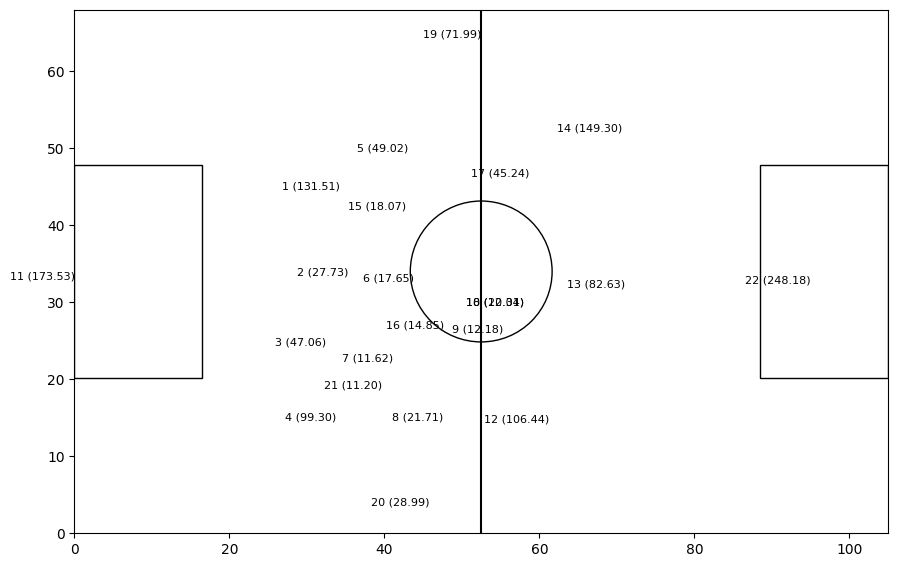

In [25]:
frame_index = 1
player_positions_x = [point[0] for point in points_22[frame_index]]
player_positions_y = [point[1] for point in points_22[frame_index]]
player_influences = influence_1half[frame_index]

# Plot the soccer field
ax = plot_soccer_field()

# Plot player positions and label with influences
label_points_with_influence(player_positions_x, player_positions_y, player_influences, ax)

plt.show()

In [26]:
# time_step = 0
# player_positions_x = [point[0] for point in points_22[frame_index]]
# player_positions_y = [point[1] for point in points_22[frame_index]]
# player_influences = influence_1half[frame_index]

# # Plot the soccer field
# ax = plot_soccer_field()

# # Plot player positions and label with influences
# label_points_with_influence(player_positions_x, player_positions_y, player_influences, ax)

# plt.show()

In [27]:
# Space occupancy is for two teams for first half is: SO_A, SO_B
# SO_A format is {(frame: Space occupancy)}
# SOA_1_zer fills zeroes in frames from 2 to 2714, since size of SO_A is 1987 and max of SO_A is 2714
# SO_A shape is 1987x1
# SO_A[frame_i] + SO_B[frame_i] = 1

indx = first_half.index.tolist()
#print(indx)
SO_A,SO_B={},{}
for coun,indexx in enumerate(indx):
 # print(coun)
  dist_1=[]
  tim = first_half.loc[indexx]['Time [s]']
  ball = ball_first[coun]
  points = points_22[indexx]
#   if coun==4:
#     print(points)
  for i in points:
    eucli = math.dist(i, ball)

    if eucli!=0:
      eucli = (1.00000000 / eucli)
      dist_1.append(eucli)
    elif eucli==0:
      eucli = 1  # if distance less than 1 meter then weightage is 1
      dist_1.append(eucli)
  IP=influence_1half[coun]


  Iteam_A = np.dot(np.array(dist_1[:11]),np.array(IP[:11]))
  Iteam_B = np.dot(np.array(dist_1[11:]),np.array(IP[11:]))

  w_a = 1/math.dist(ball, (0,68/2))
  w_b = 1/math.dist(ball, (105,68/2))
  SO_A[tim]= (w_a*Iteam_A)/((w_a*Iteam_A) + (w_b*Iteam_B))
  SO_B[tim] = (w_b*Iteam_B)/((w_a*Iteam_A) + (w_b*Iteam_B))
# print(SO_A,SO_B)
SOA_1_zer,SOB_1_zer={},{}
for i in range(2,2715,1):
  if  i in SO_A.keys():
    SOA_1_zer[i]=SO_A[i]
    SOB_1_zer[i]=SO_B[i]
  else:
    SOA_1_zer[i]=0
    SOB_1_zer[i]=0

In [28]:
# Space occupancy is for two teams for second half is: SO_A_2, SO_B_2
# SO_A_2 shape is 1458x1

indx = second_half.index.tolist()
#print(indx)
SO_A_2,SO_B_2={},{}
for coun,indexx in enumerate(indx):
 # print(coun)
  dist_1=[]
  tim = second_half.loc[indexx]['Time [s]']
  ball = ball_second[coun]
  points = points_22_final[indexx]
#   if coun==4:
#     print(points)
  for i in points:
    eucli = math.dist(i, ball)

    if eucli!=0:
      eucli = (1.00000000 / eucli)
      dist_1.append(eucli)
    elif eucli==0:
      eucli = 1  # if distance less than 1 meter then weightage is 1
      dist_1.append(eucli)
  IP=influence_2half[coun]


  Iteam_A = np.dot(np.array(dist_1[:11]),np.array(IP[:11]))
  Iteam_B = np.dot(np.array(dist_1[11:]),np.array(IP[11:]))

  w_a = 1/math.dist(ball, (105,68/2))
  w_b = 1/math.dist(ball, (0,68/2))
  SO_A_2[tim]= (w_a*Iteam_A)/((w_a*Iteam_A) + (w_b*Iteam_B))
  SO_B_2[tim] = (w_b*Iteam_B)/((w_a*Iteam_A) + (w_b*Iteam_B))
# print(SO_A_2,SO_B_2)
SOA_2_zer,SOB_2_zer={},{}
for i in range(2719,5612,1):
  if  i in SO_A_2.keys():
    SOA_2_zer[i]=SO_A_2[i]
    SOB_2_zer[i]=SO_B_2[i]
  else:
    SOA_2_zer[i]=0
    SOB_2_zer[i]=0

### SO input for ASTGCN ###

In [29]:
# converting Space occupancy values to dataframe, then to array and then saving as npz

SO_df = pd.DataFrame(list(zip(SO_A.values(), SO_B.values())), index=[int(i) for i in SO_A.keys()])
SO2_df = pd.DataFrame(list(zip(SO_A_2.values(), SO_B_2.values())), index=[int(i) for i in SO_A_2.keys()])
SO_combined = pd.concat([SO_df, SO2_df])
# Convert the DataFrame to a NumPy array
SO_combined_array = SO_combined.to_numpy()

# Save the array to a .npz file with a key
np.savez_compressed(r'C:\Users\Mahender\Documents\MS docs\Final docs\Rowan University\Research_project\ASTGCN\Space_occupancy_1.npz',
                   data=SO_combined_array)

### Influence input for ASTGCN ###

In [30]:
# storing influence of first and second half in an npz file

influence_1half_array = np.array(influence_1half)
influence_2half_array = np.array(influence_2half)
combined_influence = np.vstack((influence_1half_array, influence_2half_array))

np.savez_compressed(r'C:\Users\Mahender\Documents\MS docs\Final docs\Rowan University\Research_project\ASTGCN\Influence_1.npz',
                   data=combined_influence)

In [31]:
player_coords = np.vstack((np.array(list(points_22.values())), np.array(list(points_22_final.values()))))
# Expanding dimensions of combined_influence to make it (3445, 22, 1)
expanded_influence = np.expand_dims(combined_influence, axis=-1)

# Concatenating along the third dimension to make the new array (3445, 22, 3)
coords_inf_array = np.concatenate((expanded_influence, player_coords), axis=-1)

# Now combined_array.shape should be (3445, 22, 3)
print(coords_inf_array.shape)

np.savez_compressed(r'C:\Users\Mahender\Documents\MS docs\Final docs\Rowan University\Research_project\ASTGCN\Coords_Influence_1.npz',
                   data=coords_inf_array)
np.save(r'C:\Users\Mahender\Documents\MS docs\Final docs\Rowan University\Research_project\ASTGCN\Coords_Influence_1.npy', coords_inf_array)

(5801, 22, 3)


### Ball coords input ###

In [32]:
ball_coords = np.vstack((np.array(ball_first), np.array(ball_second)))

print(ball_coords.shape)

np.savez_compressed(r'C:\Users\Mahender\Documents\MS docs\Final docs\Rowan University\Research_project\ASTGCN\Ball_coords_1.npz',
                   data=ball_coords)

(5801, 2)


In [33]:
# input_1: adjacancy matrices
# adjacancy matrices of 22 players for all frames of first half, here points 22 is the coords of all the players in the first half
# adj_matrices_c shape is 1987x22x22

def adj_mat_c(z_c):
    adj_matrices_c = []
    dist_matrices_c = []
    for index, valu in z_c.items():
        distances = cdist(valu, valu, 'euclidean')
        dist_matrices_c.append(distances)
        adj_matrix_c = np.where(distances<15, 1, 0)
        np.fill_diagonal(adj_matrix_c, 0)
        adj_matrices_c.append(adj_matrix_c)
    return adj_matrices_c, dist_matrices_c
adj_matrices_c, dist_matrices_c =adj_mat_c(points_22)
adj_matrices_c2, dist_matrices_c2 =adj_mat_c(points_22_final)

### adj and dist matrices input for ASTGCN ###

In [34]:
# storing adjacancy and distance matrices in npzy files

adj_matrices_c_array = np.array(adj_matrices_c)
dist_matrices_c_array = np.array(dist_matrices_c)
adj_matrices_c2_array = np.array(adj_matrices_c2)
dist_matrices_c2_array = np.array(dist_matrices_c2)

combined_adj_matrices = np.vstack((adj_matrices_c_array, adj_matrices_c2_array))
combined_dist_matrices = np.vstack((dist_matrices_c_array, dist_matrices_c2_array))

np.save(r'C:\Users\Mahender\Documents\MS docs\Final docs\Rowan University\Research_project\ASTGCN\adj_matrices_1.npy', combined_adj_matrices)
np.save(r'C:\Users\Mahender\Documents\MS docs\Final docs\Rowan University\Research_project\ASTGCN\dist_matrices_1.npy', combined_dist_matrices)

In [35]:
np.save(r'C:\Users\Mahender\Documents\MS docs\Final docs\Rowan University\Research_project\ASTGCN\initial_adj_matrices_1.npy', combined_adj_matrices[0])
np.save(r'C:\Users\Mahender\Documents\MS docs\Final docs\Rowan University\Research_project\ASTGCN\initial_dist_matrices_1.npy', combined_dist_matrices[0])

In [36]:
print(combined_influence[:,20])

[10.92436975 11.20448179 13.7254902  ... 40.89635854 41.03641457
 40.89635854]


In [37]:
# coords of players for all frames without frame values

nested_x_y = [[np.array(t) for t in sublist] for i,sublist in points_22.items()]
for i,j in enumerate(nested_x_y):
  nested_x_y[i]=np.array(j)

In [38]:
# scipy.sparse.csr_matrix is just a better way to store matrix for faster performance in matrix operations

import scipy.sparse as sp
adj_matrices=[]
for i,j in enumerate(adj_matrices_c):
  adj_matrices.append(sp.csr_matrix(j))

In [39]:
# Space occupancy without frame

SO_A[list(SO_A.keys())[0]]
SO_A_li=[i for j,i in SO_A.items()]

In [40]:
data={}
data['adj']=adj_matrices
data['x']=nested_x_y
data['x'] = [np.append(x,np.ones(shape=(len(x), 1)), axis=1
            ) for x in data['x']]

In [41]:
# creating edges

ed=[]
for i,j in points_22.items():
  for k in j:
    print(k)
    break
  break

len(points_22[33550])

# for i,j in points_22.items():
#   distances = cdist(j, j, 'euclidean')
#   np.fill_diagonal(distances, 0)
#   empty_array_e = np.empty((0,))
#   for p in distances:
#     for  pd in p:
#     #   empty_array = np.array([])
#     #   empty_array = np.append(empty_array, np.array([pd]))
#       empty_array_e = np.vstack((empty_array_e, np.array([pd])))


#   ed.append(empty_array_e)

for i,j in points_22.items():
  distances = cdist(j, j, 'euclidean')
  np.fill_diagonal(distances, -1)
  l=[]
  for row,p in enumerate(distances):
    for column, p_d in enumerate(p):
      if p_d<15 and p_d!=-1:
        li=[]
        li.append(p_d)
        l.append(li)

  ed.append(l)
for ind,i in enumerate(ed):

  for ik,k in enumerate(i):
    i[ik]=np.array(k)

  ed[ind]=np.array(i)
for i in ed:
  for j in i:
    if len(j)!=1:
      raise Exception

(34.2804, 44.41896)


In [42]:
data['e']=ed

In [43]:
# from spektral.data import Dataset, Graph

# class CounterDataset(Dataset):
#     def __init__(self,  **kwargs):
#         super().__init__(**kwargs)
#         self.data = kwargs['data']
#         self.SO_A = kwargs['SO_A']

#     def read(self):
#         data=self.data
#         graphs = []
#         for adj_matrix,x, e,label in zip(data['adj'],data['x'],data['e'], self.SO_A):
#             graph = Graph(x=x,a=adj_matrix, e=e, y=label)
#             graphs.append(graph)
#         return graphs

In [44]:
# dataset = CounterDataset(data=data,SO_A= SO_A_li)

In [45]:
# pip install torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html

In [46]:
# pip install torch_geometric_temporal

In [47]:
# from torch_geometric_temporal.nn.attention import ASTGCN   # For information about the architecture check the source code

In [48]:
# nb_block = 2
# in_channels = 1
# K = 3
# nb_chev_filter = 64
# nb_time_filter = 64
# time_strides = num_of_hours
# num_for_predict = 12
# len_input = 12
# #L_tilde = scaled_Laplacian(adj_mx)
# #cheb_polynomials = [torch.from_numpy(i).type(torch.FloatTensor).to(DEVICE) for i in cheb_polynomial(L_tilde, K)]
# net = ASTGCN( nb_block, in_channels, K, nb_chev_filter, nb_time_filter, time_strides, num_for_predict, len_input, num_of_vertices).to(DEVICE)

# print(net)
